In [1]:
# Calibrate camera based on the checkerboard pattern data


In [2]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import glob


In [9]:
# Calibrate camera function
def calibrate_camera(folderpath, square_size, width=9, height=6,
                     flag_show_checkerboard_images=False,
                     flag_save_cals = False):
    
    
    # Make the object points in World. Z=0 for the object plane
    # Example object points (0,0,0), (1,0,0) (2,0,0) ... (7,5,0), (8,5,0)
    
    objpts = np.zeros((height*width,3), np.float32)
    
    #Create the grid for X aand Y points
#     objpts[:,:2] = np.mgrid[0:width, 0:height].T.reshape(-1,2)
    xx,yy = np.meshgrid(np.arange(0,width,1), np.arange(0,height,1))
    
    # Reshape into 1d array
    xx = xx.reshape(-1)
    yy = yy.reshape(-1)
    
    # Update coordinates of the XY points 
    objpts[:,0] = xx
    objpts[:,1] = yy    

    # Sacle by the true size
    objpts = square_size* objpts
    
    print("Object points are: \n", objpts)
#     print(objpts)
    
    # Create the arrays to store the object points and image points for all images
    objPointsArray = []
    imagePointsArray = []
    
    
    # Termination criteria for stopping subpixel corner calculation
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.01)

    
    #Get all the images
    images = os.listdir(folderpath)
    #images = glob.glob(folderpath)
    
    print(images)
#     return

    
    print("Reading images from folder: " + folderpath)
    
    idx=0
    for fname in images:

        if not '.jpg' in fname:
            continue
        
        print("Running {}/{} image".format(idx,len(images)))
        try:
            
            current_fname = os.path.join(folderpath,fname)
            print("Processing Image: ", current_fname)
            img = cv2.imread(current_fname) # Read as grayscale
            gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

            print("Height: {}, Width: {}".format(gray.shape[0],gray.shape[1]))
            
            #Find the chessboard corners
            ret,corners = cv2.findChessboardCorners(gray,(width,height),
                                                   cv2.CALIB_CB_ADAPTIVE_THRESH 
                                                    + cv2.CALIB_CB_FAST_CHECK 
                                                    + cv2.CALIB_CB_NORMALIZE_IMAGE)

            #If the corners are detected, run subpixel accuracy
            if ret:

                print("Initial corners found")

                #Append the object points
                objPointsArray.append(objpts)
                corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)

                # Append the image pts
                imagePointsArray.append(corners2)

                # Draw the corners
                img = cv2.drawChessboardCorners(img,(width,height),corners2,ret)


                if(flag_show_checkerboard_images):
                    plt.imshow(img, cmap='gray')
                    plt.show()

            else:
                print("Error detecting corners in this image ")

        except:
            print("error")
            
        idx = idx+1
                
    # Once all the calibration files have been processed, run the calibrate camera using Zhang's method on this data
    retval, cameraMatrix, distCoeffs, rvecs, tvecs = cv2.calibrateCamera(objPointsArray,imagePointsArray,img.shape[:2],None,None)
    
    # Save the values of the cameraMatrix and the distortion ccoeffs
    if flag_save_cals:
        np.save("calibration_matrix", cameraMatrix)
        np.save("distCoeffs", distCoeffs)
    
    print("Calculating the Reprojection Error")
    # Calculate the reprojection error
    mean_error = 0
    numImageUsed = len(objPointsArray)
    for i in range(numImageUsed):
        # Project object pts to image coordinates 
        imgpts2, _ = cv2.projectPoints(objPointsArray[i],
                                       rvecs[i],tvecs[i],
                                       cameraMatrix,distCoeffs)
        
        # Calculate error in these projected points and the actual captured points
        error = cv2.norm(imagePointsArray[i] - imgpts2,cv2.NORM_L2)/len(imgpts2)
        
        print("Reprojection Error for image {}/{} = {:.3f}px".format(i,numImageUsed,error))
        
        mean_error+=error
 
    mean_error /= numImageUsed
    print("Mean Error for the dataset is: {}px".format(mean_error))
    print("Reprojection error below 1 px is generally considered a good result.")

 
        
    
    return [retval, cameraMatrix, distCoeffs, rvecs, tvecs]
    

#Set the variables
folderpath = "images/calibrate_camera_images"
width = 8 # Width of checkerboard
height = 6 # Height of checkerboard pattern
square_size = 25 # Length of edge of square in meters 25mm
flag_show_checkerboard_images = True
save_cals = True

    

Object points are: 
 [[  0.   0.   0.]
 [ 25.   0.   0.]
 [ 50.   0.   0.]
 [ 75.   0.   0.]
 [100.   0.   0.]
 [125.   0.   0.]
 [150.   0.   0.]
 [175.   0.   0.]
 [  0.  25.   0.]
 [ 25.  25.   0.]
 [ 50.  25.   0.]
 [ 75.  25.   0.]
 [100.  25.   0.]
 [125.  25.   0.]
 [150.  25.   0.]
 [175.  25.   0.]
 [  0.  50.   0.]
 [ 25.  50.   0.]
 [ 50.  50.   0.]
 [ 75.  50.   0.]
 [100.  50.   0.]
 [125.  50.   0.]
 [150.  50.   0.]
 [175.  50.   0.]
 [  0.  75.   0.]
 [ 25.  75.   0.]
 [ 50.  75.   0.]
 [ 75.  75.   0.]
 [100.  75.   0.]
 [125.  75.   0.]
 [150.  75.   0.]
 [175.  75.   0.]
 [  0. 100.   0.]
 [ 25. 100.   0.]
 [ 50. 100.   0.]
 [ 75. 100.   0.]
 [100. 100.   0.]
 [125. 100.   0.]
 [150. 100.   0.]
 [175. 100.   0.]
 [  0. 125.   0.]
 [ 25. 125.   0.]
 [ 50. 125.   0.]
 [ 75. 125.   0.]
 [100. 125.   0.]
 [125. 125.   0.]
 [150. 125.   0.]
 [175. 125.   0.]]
['IMG_4722.jpg', 'IMG_4723.jpg', 'IMG_4724.jpg', 'IMG_4725.jpg', 'IMG_4726.jpg', 'IMG_4727.jpg', 'IMG_4728.jpg', '

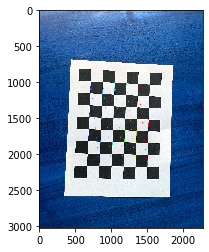

Running 1/21 image
Processing Image:  images/calibrate_camera_images\IMG_4723.jpg
Height: 3024, Width: 2268
Initial corners found


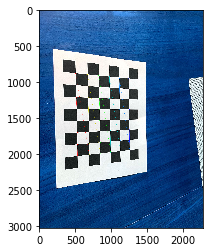

Running 2/21 image
Processing Image:  images/calibrate_camera_images\IMG_4724.jpg
Height: 3024, Width: 2268
Initial corners found


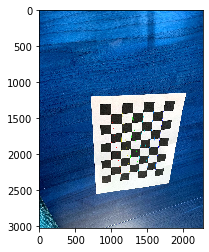

Running 3/21 image
Processing Image:  images/calibrate_camera_images\IMG_4725.jpg
Height: 3024, Width: 2268
Initial corners found


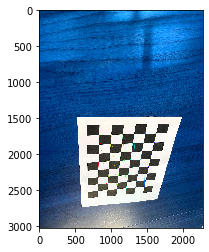

Running 4/21 image
Processing Image:  images/calibrate_camera_images\IMG_4726.jpg
Height: 3024, Width: 2268
Initial corners found


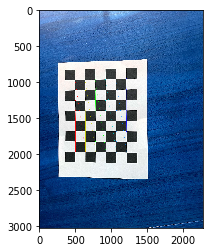

Running 5/21 image
Processing Image:  images/calibrate_camera_images\IMG_4727.jpg
Height: 3024, Width: 2268
Initial corners found


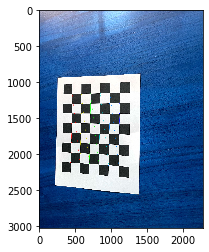

Running 6/21 image
Processing Image:  images/calibrate_camera_images\IMG_4728.jpg
Height: 3024, Width: 2268
Initial corners found


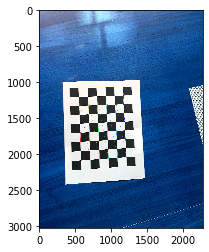

Running 7/21 image
Processing Image:  images/calibrate_camera_images\IMG_4730.jpg
Height: 3024, Width: 2268
Initial corners found


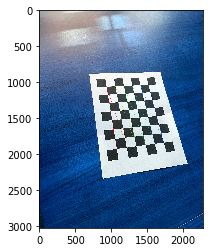

Running 8/21 image
Processing Image:  images/calibrate_camera_images\IMG_4731.jpg
Height: 3024, Width: 2268
Initial corners found


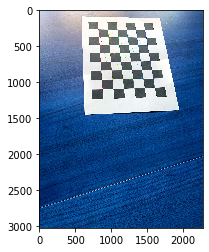

Running 9/21 image
Processing Image:  images/calibrate_camera_images\IMG_4732.jpg
Height: 3024, Width: 2268
Initial corners found


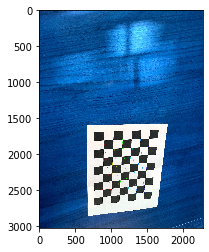

Running 10/21 image
Processing Image:  images/calibrate_camera_images\IMG_4733.jpg
Height: 3024, Width: 2268
Initial corners found


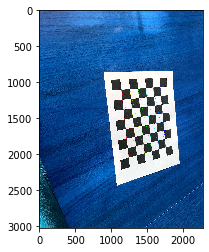

Running 11/21 image
Processing Image:  images/calibrate_camera_images\IMG_4734.jpg
Height: 3024, Width: 2268
Initial corners found


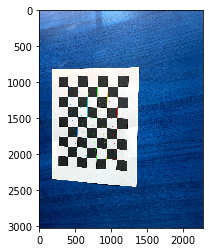

Running 12/21 image
Processing Image:  images/calibrate_camera_images\IMG_4735.jpg
Height: 3024, Width: 2268
Initial corners found


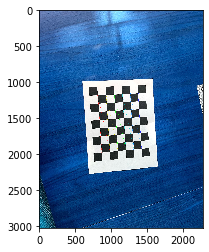

Running 13/21 image
Processing Image:  images/calibrate_camera_images\IMG_4736.jpg
Height: 3024, Width: 2268
Initial corners found


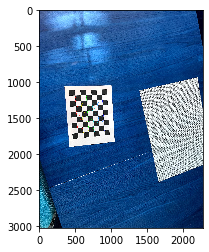

Running 14/21 image
Processing Image:  images/calibrate_camera_images\IMG_4737.jpg
Height: 3024, Width: 2268
Initial corners found


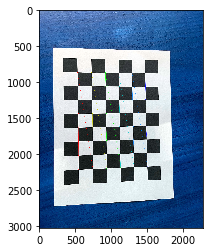

Running 15/21 image
Processing Image:  images/calibrate_camera_images\IMG_4738.jpg
Height: 3024, Width: 2268
Initial corners found


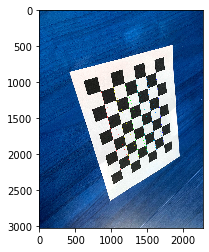

Running 16/21 image
Processing Image:  images/calibrate_camera_images\IMG_4739.jpg
Height: 3024, Width: 2268
Initial corners found


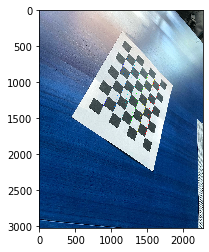

Running 17/21 image
Processing Image:  images/calibrate_camera_images\IMG_4741.jpg
Height: 3024, Width: 2268
Initial corners found


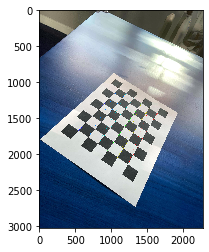

Running 18/21 image
Processing Image:  images/calibrate_camera_images\IMG_4744.jpg
Height: 3024, Width: 2268
Initial corners found


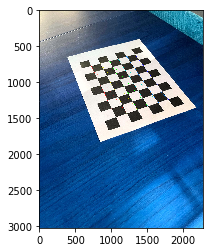

Calculating the Reprojection Error
Reprojection Error for image 0/19 = 0.055px
Reprojection Error for image 1/19 = 0.131px
Reprojection Error for image 2/19 = 0.038px
Reprojection Error for image 3/19 = 0.041px
Reprojection Error for image 4/19 = 0.057px
Reprojection Error for image 5/19 = 0.056px
Reprojection Error for image 6/19 = 0.127px
Reprojection Error for image 7/19 = 0.049px
Reprojection Error for image 8/19 = 0.044px
Reprojection Error for image 9/19 = 0.043px
Reprojection Error for image 10/19 = 0.048px
Reprojection Error for image 11/19 = 0.069px
Reprojection Error for image 12/19 = 0.069px
Reprojection Error for image 13/19 = 0.061px
Reprojection Error for image 14/19 = 0.061px
Reprojection Error for image 15/19 = 0.091px
Reprojection Error for image 16/19 = 0.052px
Reprojection Error for image 17/19 = 0.076px
Reprojection Error for image 18/19 = 0.074px
Mean Error for the dataset is: 0.06530291734627108px
Reprojection error below 1 px is generally considered a good result

In [10]:
output = calibrate_camera(folderpath,
                          square_size, 
                          width,height,
                          flag_show_checkerboard_images,
                          save_cals)    


In [12]:
# Print all the returned values:
[retval, cameraMatrix, distCoeffs, rvecs, tvecs] = output

print("The results of the camera calibration are:")
print("retval (opencv calculated reprojection error in px) is : \n {}px \n ".format(retval))
print("cameraMatrix is : \n {} \n ".format(cameraMatrix))
print("distCoeffs are  : \n {} \n ".format(distCoeffs))
print("Rotation vector for the images are : \n {} \n ".format(rvecs))
print("Translational vector for the images are : \n {} \n ".format(tvecs))



The results of the camera calibration are:
retval (opencv calculated reprojection error in px) is : 
 0.4855857518095219px 
 
cameraMatrix is : 
 [[2.30155415e+03 0.00000000e+00 1.13409396e+03]
 [0.00000000e+00 2.30321381e+03 1.52116518e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] 
 
distCoeffs are  : 
 [[ 1.76501798e-01 -6.62903260e-01 -5.19351920e-04  6.69463054e-04
   9.61475869e-01]] 
 
Rotation vector for the images are : 
 [array([[ 0.02560229],
       [-0.08045656],
       [-1.53300359]]), array([[-0.32322956],
       [-0.35041605],
       [ 1.52598743]]), array([[ 0.17986908],
       [-0.50352648],
       [ 1.51406614]]), array([[ 0.2684513 ],
       [-0.56241176],
       [ 1.56250271]]), array([[0.07633686],
       [0.0807662 ],
       [1.56558544]]), array([[0.16328557],
       [0.19264434],
       [1.57637288]]), array([[-0.1055677 ],
       [-0.01299178],
       [ 1.5229615 ]]), array([[-0.45358478],
       [ 0.10116836],
       [ 1.41048847]]), array([[-0.35234695